In [1]:
%matplotlib inline
from collections import defaultdict
import pymc as pm
from pymc.Matplot import plot as mcplot
import numpy as np
from matplotlib import pyplot as plt
import json
from pymongo import MongoClient
import pymongo
from bson.objectid import ObjectId
import random

In [3]:
def random_limit(distribution):
    val = distribution.random()
    while val > 1 or val < 0:
        val = distribution.random()
    return val

class grader(object):
    def __init__(self, name,bias_mean,bias_tau):
        self.name = name
        self.handins = list()
        self.bias_mean = bias_mean
        self.bias_tau = bias_tau
        
    def add_handin(self, handin):
        self.handins.append(handin)
                
    def grade_handins(self):
        for handin in self.handins:
            B = pm.Normal('B_generator',self.bias_mean,self.bias_tau)
            handin.add_gradeing(self,B.random())

class handin:
    def __init__(self,title,owner,true_value,precision):
        self.title = title
        self.owner = owner
        self.gradeings = dict()
        self.graders = list()
        self.true_val = true_value
        self.precision = precision
    
    def add_grader(self,grader):
        self.graders.append(grader)
    
    def add_gradeing(self,grader,bias):
        obs = pm.Normal('obs_generator',self.true_val+bias,self.precision)
        self.gradeings[grader.name] = random_limit(obs)
        
        
class assignment(object):
    
    def __init__(self, handins_input, graders_input):
        self.handins = dict()
        self.graders = dict()
        for handin in handins_input:
            self.handins[handin.title] = handin
        for grader in graders_input:
            self.graders[grader.name] = grader
    
    def add_handin(self, handin):
        self.handing[handin.title] = handin
        
    def add_grader(self, grader):
        self.graders[grader.title] = grader
    
    def find_ungraded_handin(self, grader):
        
        # sort the handins by the one with the least
        sorted_l = sorted(self.handins.values(),key=lambda x: len(x.graders))
        #i = int(random.uniform(0,len(sorted_l)))
        i = 0
        handin = sorted_l[i]
        while handin in grader.handins or (handin.owner.name == grader.name):
        #while(handin.owner.name == grader.name):
            i += 1
            #i = int(random.uniform(0,len(sorted_l)))
            handin = sorted_l[i]
        return handin
            
    def grade_handins(self,n_handins):
        # Distribute handins
        for i in xrange(0,n_handins):
            for grader in self.graders.itervalues():
                h = self.find_ungraded_handin(grader)
                h.add_grader(g)
                grader.add_handin(h)
                
        # grade handins
        for grader in self.graders.itervalues():
            grader.grade_handins()

In [28]:
def generate_data(graders, handins):
    T_mu = pm.Normal('T_mu_generator',0.5,25)
    T_tau = pm.Gamma('T_tau_generator',10,0.1)
    B_mu = pm.Normal('B_mu_generator',0,100)
    B_tau = pm.Gamma('B_tau_generator',50,0.1)

    handins_data = list()
    graders_data = list()

    for i in xrange(0,graders):
        g = grader('grader_%i' % i,B_mu.random(),B_tau.random())
        t_mu = random_limit(T_mu)
        h = handin('handin_%i' % i, g, t_mu, T_tau.random())
        graders_data.append(g)
        handins_data.append(h)

    assignment_data = assignment(handins_data,graders_data)
    assignment_data.grade_handins(handins)
    return assignment_data

In [72]:
def generate_data_2(assignments, graders, handins):
    T_mu = pm.Normal('T_mu_generator', 0.5, 25)
    T_tau = pm.Gamma('T_tau_generator', 10, 0.1)
    B_mu = pm.Normal('B_mu_generator', 0, 100)
    B_tau = pm.Gamma('B_tau_generator', 50, 0.1)

    handins_data = list()
    graders_data = list()
    for i in xrange(0, graders):
        g = grader('grader_%i' % i, B_mu.random(), B_tau.random())
        graders_data.append(g)

    for a in xrange(0, assignments):

        handins_data_e = list()
        grader_min = graders * a
        grader_max = grader_min + graders
        for i in xrange(grader_min, grader_max):
            t_mu = random_limit(T_mu)
            h = handin('handin_%i' % i, graders_data[i-grader_min], t_mu, T_tau.random())
            handins_data.append(h)

    assignment_data = assignment(handins_data, graders_data)
    assignment_data.grade_handins(handins)

    return assignment_data

In [73]:
generate_data_2(2,10,5)

In [5]:
def Model(data):
    N_H = len(data)
    
    # Bias
    T_tau = dict()
    T_mu = dict()
    B_mu = dict()
    B_tau = dict()
    O = list()

    for h in range(0, N_H):
        h_id = data[h].title
        scores = data[h].gradeings.items()
        
        N_G = len(scores)
        T_mu[h_id] = pm.Normal('T_mu_%s' % str(h_id),0.5,25)
        T_tau[h_id] = pm.Gamma('T_tau_%s' % str(h_id),10,0.1)
        
        for g in range(0, N_G):
            (g_id,val) = scores[g]
            
            if g_id not in B_mu:
                B_mu[g_id] = pm.Normal('B_mu_%s' % str(g_id),0,100)
            if g_id not in B_tau:
                B_tau[g_id] = pm.Gamma('B_tau_%s' % str(g_id), 50, 0.1)
                
            O.append(pm.Normal('O_%(h)i_%(g)i' % {'h': h, 'g':g}, mu = T_mu[h_id] + B_mu[g_id], tau=T_tau[h_id] + B_tau[g_id], observed=True, value=val))
               
    collection = [pm.Container(T_mu),
                  pm.Container(T_tau),
                  pm.Container(B_mu),
                  pm.Container(B_tau),
                  pm.Container(O)]
    
    model = pm.Model(collection)
#    map_ = pm.MAP(model)
#    map_.fit()
    return model

In [29]:
def execute_model_map(model,samples):
    map_ = pm.MAP(model)
    map_.fit()
    mcmc = pm.MCMC(model)
    mcmc.sample(samples)
    return mcmc

In [34]:
def execute_model_no_map(model, samples, burn):
    mcmc = pm.MCMC(model)
    mcmc.sample(samples,burn=burn)
    return mcmc

In [35]:
def build_mcmc(model_,values):
    return model_(values)

In [36]:
def find_bias(assignment,mcmc,f):
    bias = list()
    for g in assignment.graders.keys():
        value = 0
        if f == 'var':
            value = np.mean(mcmc.trace('B_tau_%s' % str(g))[:])
        elif f == 'mean':
            value = np.mean(mcmc.trace('B_mu_%s' % str(g))[:])
        bias.append((value,g))
    return bias

In [37]:
def find_T(assignment,mcmc,f):
    T = list()
    for h in assignment.handins.keys():
        value = 0
        if f == 'var':
            value = np.mean(mcmc.trace('T_tau_%s' % str(h))[:])
        elif f == 'mean':
            value = np.mean(mcmc.trace('T_mu_%s' % str(h))[:])
        T.append((value,h))
    return T

In [45]:
def find_MSE(assignment_data,mcmc_handins,find, func='mean'):
    found = find(assignment_data, mcmc_handins, func)
    
    # Generate dict of the found values in each run for each grader
    compared = defaultdict(list)
    collected = list()
    collected = found[:]
    
    for (value, _id) in collected:
        compared[_id].append(value)

    sorted_list = list()
    if find.func_name == "find_bias":
        for _id, g in assignment_data.graders.iteritems():
            if func == "mean":
                sorted_list.append((_id,g.bias_mean))
            else:
                sorted_list.append((_id,g.bias_tau))
    else:
        for _id, h in assignment_data.handins.iteritems():
            if func == "mean":
                sorted_list.append((_id,h.true_val))
            else:
                sorted_list.append((_id,h.precision))
            
    sorted_list.sort(key=lambda x: x[1])

#    ax = plt.subplot(111)
    
    labels = list()
    true_values = list()
    score_values = list()
    mean_score_values = list()
    MS_val = list()
    y = xrange(0,len(sorted_list))
    for (_id, value) in sorted_list:
#        if find.func_name != "find_bias" and func == "mean":
#            mean_score = np.mean(assignment_data.handins[_id].gradeings.values())
#            mean_score_values.append(mean_score)
        
        MS_val.append(np.mean(compared[_id]))
        score_values.append(compared[_id])
        true_values.append(value)
        labels.append(_id)
    
#    MSE_T = 0.0
    MSE_M = sum(map(lambda x : (float(x[1]) - float(x[0])) ** 2,zip(true_values,MS_val))) / len(true_values)
#    print MSE_M
#    if find.func_name != "find_bias" and func == "mean":
#        MSE_T = sum(map(lambda x : (float(x[1]) - float(x[0])) ** 2,zip(true_values,mean_score_values))) / len(true_values)
#        print MSE_T
#    box_text = ""
#    if find.func_name != "find_bias" and func == "mean":
#    box_text = 'MSE model: %(h)f\nMSE graded: %(g)f' % {'h': MSE_M, 'g':MSE_T}
#    else:
    return MSE_M

## Test 1

First test is with 20 graders and 10 grading per graders
The model with no MAP will have 10000 sample

In [39]:
print "Generating data"
%time data = generate_data(20,10)
print "Building model"
%time mcmc = build_mcmc(Model,data.handins.values())
print "Executing model with no MAP"
%time result_no_map = execute_model_no_map(mcmc,10000,2500)
print "Executing model with MAP"
%time result_map = execute_model_map(mcmc,2000)

Generating data
CPU times: user 189 ms, sys: 11.5 ms, total: 200 ms
Wall time: 196 ms
Building model
CPU times: user 967 ms, sys: 15.1 ms, total: 982 ms
Wall time: 995 ms
Executing model with no MAP
 [-----------------100%-----------------] 10000 of 10000 complete in 222.1 secCPU times: user 3min 35s, sys: 1.75 s, total: 3min 37s
Wall time: 3min 43s
Executing model with MAP
 [-----------------100%-----------------] 2000 of 2000 complete in 44.2 secCPU times: user 1min 27s, sys: 755 ms, total: 1min 28s
Wall time: 1min 30s


In [46]:
print "No MAP used: " + str(find_MSE(data,result_no_map,find_bias))
print "MAP used: " + str(find_MSE(data,result_map,find_bias))

No MAP used: 0.00163957206108
MAP used: 0.00172477477269


## Test 2

First test is with 100 graders and 5 grading per graders
The model with no MAP will have 10000 sample and 2500 burn in
Modle with MAP will only have 2000 samples and no burn in as it is not needed

In [47]:
print "Generating data"
%time data = generate_data(100,5)
print "Building model"
%time mcmc = build_mcmc(Model,data.handins.values())
print "Executing model with no MAP"
%time result_no_map = execute_model_no_map(mcmc,10000,2500)
print "Executing model with MAP"
%time result_map = execute_model_map(mcmc,2000)

Generating data
CPU times: user 466 ms, sys: 10.6 ms, total: 477 ms
Wall time: 486 ms
Building model
CPU times: user 1.6 s, sys: 61 ms, total: 1.66 s
Wall time: 1.84 s
Executing model with no MAP
 [-----------------100%-----------------] 10000 of 10000 complete in 706.3 secCPU times: user 11min 33s, sys: 4.76 s, total: 11min 38s
Wall time: 11min 49s
Executing model with MAP
 [-----------------100%-----------------] 2001 of 2000 complete in 146.0 secCPU times: user 17min 29s, sys: 6.88 s, total: 17min 36s
Wall time: 17min 52s


In [48]:
print "No MAP used: " + str(find_MSE(data,result_no_map,find_bias))
print "MAP used: " + str(find_MSE(data,result_map,find_bias))

No MAP used: 0.00324896490478
MAP used: 0.00348308582633


## Test 3

First test is with 200 graders and 5 grading per graders
The model with no MAP will have 10000 sample and 2500 burn in
Modle with MAP will only have 2000 samples and no burn in as it is not needed

In [49]:
print "Generating data"
%time data = generate_data(200,5)
print "Building model"
%time mcmc = build_mcmc(Model,data.handins.values())

Generating data
CPU times: user 952 ms, sys: 16.6 ms, total: 968 ms
Wall time: 987 ms
Building model
CPU times: user 2.49 s, sys: 88.7 ms, total: 2.58 s
Wall time: 2.64 s


In [50]:
print "Executing model with no MAP"
%time result_no_map = execute_model_no_map(mcmc,10000,2500)

Executing model with no MAP
 [-----------------100%-----------------] 10000 of 10000 complete in 1433.5 secCPU times: user 23min 31s, sys: 8.96 s, total: 23min 40s
Wall time: 23min 59s


In [51]:
print "Executing model with MAP"
%time result_map = execute_model_map(mcmc,2000)

Executing model with MAP
 [-----------------100%-----------------] 2000 of 2000 complete in 365.6 secCPU times: user 2h 4min 18s, sys: 1min 20s, total: 2h 5min 39s
Wall time: 18h 19min 55s


In [ ]:
print "No MAP used: " + str(find_MSE(data,result_no_map,find_bias))
print "MAP used: " + str(find_MSE(data,result_map,find_bias))

## Multiple test

I have run different kind of test with the following parameters

There are 3 different data set. 
First set contains 1 assignment with 5 grading each. Executed with 10, 20, 50 and 100 graders
Second set contains 1 assignment but with 10 grading each. Executed with 20 50 and 100 grader.
Third set contains 2 assignment with 5 grading each. Executed with 10, 20 50 and 100 grader.
MCMC is used on both models twice. First without using MAP with 10000 samples and 2500 samples are burn in. MAP is used for the second with 2500 samples.
The Mean Square Error is found for both models.

In [111]:
data = [('1 ass, 5 gradings',(1,5),[(10,(52.926037,17.394718),(0.00741566416253,0.0038712763065)),
                                    (25,(135.434134,83.110631),(0.00172148892856,0.00198619501123)),
                                    (50,(263.826781,251.480387),(0.00311335560883,0.00333418202202)),
                                    (75,(405.950860,623.360426),(0.00342984235016,0.00357793749179)),
                                    (100,(510.913396,2178.053913),(0.0027808105486,0.00291477169647))]),
        ('1 ass, 10 gradings',(1,10),[(11,(92.606165,29.251512),(0.000920858289528,0.000909238545598)),
                                      (25,(209.142092,85.174184),(0.00191445167068,0.00207297092275)),
                                      (50,(441.984698,412.450215),(0.00265583792402,0.00253389142967)),
                                      (75,(680.459289,525.915773),(0.00202617517182,0.0021086392097)),
                                      (100,(896.673104,1450.916012),(0.00167275229378,0.00198124916808))]),
        ('2 ass, 5 gradings',(2,5),[(10,(95.868462,34.399942),(0.00159022225517,0.00161970533525)),
                                    (25,(238.818824,104.504534),(0.00221384241717,0.00223938034666)),
                                    (50,(493.209580,662.198828),(0.00223482632479,0.0023394252599)),
                                    (75,(789.314926,1281.555315),(0.00181455776138,0.00184482617533)),
                                    (100,(1038.258642,2829.493589),(0.00180588098216,0.0022923245892))])]

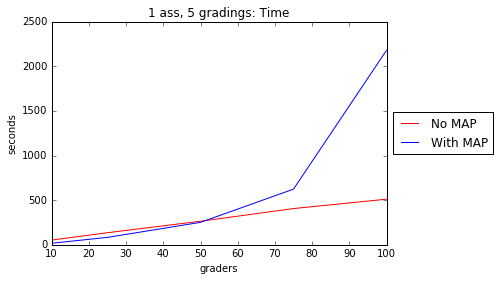

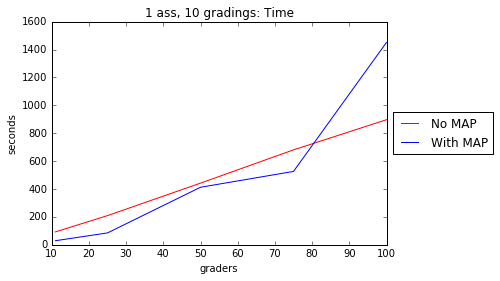

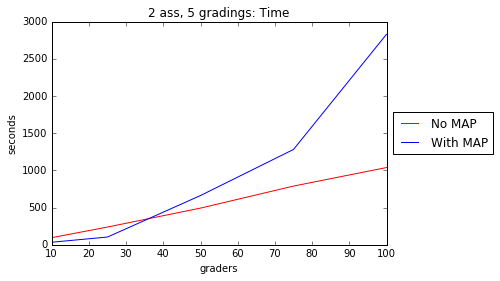

In [114]:
for i, (name,(ass,gradings),values) in enumerate(data):
    index = list()
    time_1 = list()
    time_2 = list()
    MSE_1 = list()
    MSE_2 = list()
    for (graders, (t_1,t_2), (M_1,M_2)) in values:
        index.append(graders)
        time_1.append(t_1)
        time_2.append(t_2)
        MSE_1.append(M_1)
        MSE_2.append(M_2)
        
    ax = plt.subplot(1,1,1) 
    
    plt.plot(index,time_1,'r',label="No MAP")
    plt.plot(index,time_2,'b',label="With MAP")
    
    plt.title(name + ": Time")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel("seconds")
    plt.xlabel("graders")
    box = ax.get_position()
    ax.set_position([box.x0, box.y0,
                     box.width, box.height])
    plt.show()

From the plot we can see that that the execution time increases linear with the number of additional parameters when MAP is not used. But with MAP the time increases exponential with the number of graders which add more parameters to that MAP as to estimate.
Even with a lower number of parameters, MAP does not provide an increase in computation time.

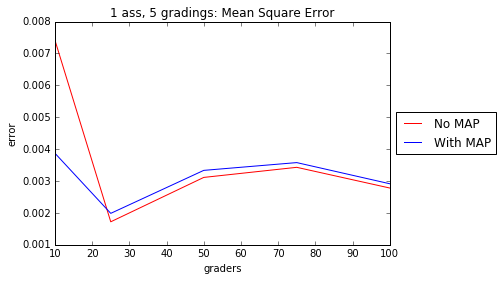

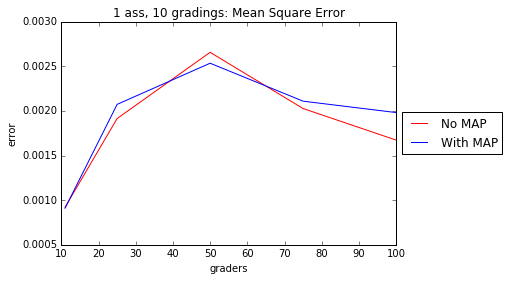

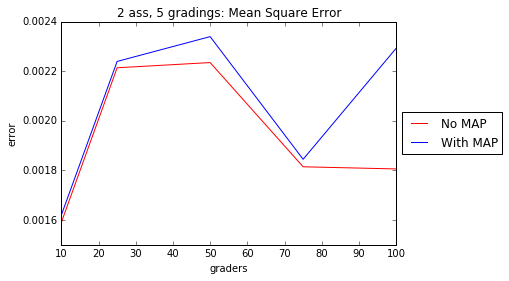

In [116]:
for i, (name,(ass,gradings),values) in enumerate(data):
    index = list()
    time_1 = list()
    time_2 = list()
    MSE_1 = list()
    MSE_2 = list()
    for (graders, (t_1,t_2), (M_1,M_2)) in values:
        index.append(graders)
        time_1.append(t_1)
        time_2.append(t_2)
        MSE_1.append(M_1)
        MSE_2.append(M_2)
        
    ax = plt.subplot(1,1,1) 

    plt.plot(index,MSE_1,'r',label="No MAP")
    plt.plot(index,MSE_2,'b',label="With MAP")

    plt.ylabel("error")
    plt.xlabel("graders")
    plt.title(name + ": Mean Square Error")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    box = ax.get_position()
    ax.set_position([box.x0, box.y0,
                     box.width, box.height])
    plt.show()

Precision wise the two methods mostely result in the same Mean Square Error but theire are some outliers which are the result of using MCMC which will provide an apporoximation of the parameters in the model.